<a href="https://colab.research.google.com/github/DRA-chaos/Comparing-the-performance-of-a-binary-QNN-classifier-on-different-Hardware-Accelerators/blob/main/Changing_layers_in_the_QML_model_CPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 14 kB/s 
     |████████████████████████████████| 462 kB 70.0 MB/s 
     |████████████████████████████████| 3.8 MB 58.1 MB/s 
     |████████████████████████████████| 2.9 MB 47.5 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.

In [ ]:
!pip install tensorflow-quantum

     |████████████████████████████████| 7.8 MB 6.0 MB/s 
     |████████████████████████████████| 90 kB 11.5 MB/s 
     |████████████████████████████████| 5.6 MB 31.4 MB/s 
     |████████████████████████████████| 1.3 MB 68.8 MB/s 
     |████████████████████████████████| 100 kB 11.1 MB/s 
     |████████████████████████████████| 90 kB 9.9 MB/s 
     |████████████████████████████████| 1.5 MB 49.8 MB/s 
     |████████████████████████████████| 380 kB 74.7 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 92 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 92 kB 1.3 MB/s 
     |████████████████████████████████| 92 kB 1.2 MB/s 
     |██████████████████████████████

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# **Loading raw MNIST data**


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescaling images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  #Normalization

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


**We filter the dataset to first classify / recognize only 2 and 4. We make the label y into a boolean variable, true for 2 and false for 4**


In [ ]:
def filter_24(x, y):
    keep = (y == 2) | (y == 4)
    x, y = x[keep], y[keep]
    y = y == 2
    return x,y

In [ ]:
x_train, y_train = filter_24(x_train, y_train)
x_test, y_test = filter_24(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11800
Number of filtered test examples: 2014


First example from the dataset printed just for reference

False


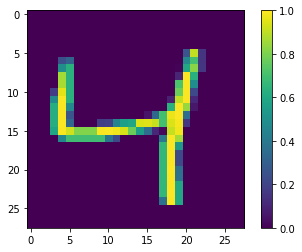

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

# **Downscaling the Image. Resizing is necessary because 28x28 is too large a dimension**

# In this code, I initially tried sclaing it to 5x5 but it took way too long to execute, so I chose the scaling size to be at 3x3. 

In [ ]:
x_train_small = tf.image.resize(x_train, (3,3)).numpy()
x_test_small = tf.image.resize(x_test, (3,3)).numpy()

Displaying the first training example- after resize

False


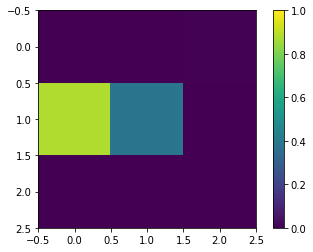

In [ ]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

# **Filtering the dataset to remove samples that belong to both classes so as to improve the performance and accuracy of classification**

In [ ]:
##not necessary
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_2 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_4 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 2s: ", num_uniq_2)
    print("Number of unique 4s: ", num_uniq_4)
    print("Number of unique contradicting labels (both 2 and 4): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

In [ ]:
x_train_nocon, y_train_nocon = x_train_small, y_train

## We now encode data using binary encoding into Quantum Circuits

In [ ]:
#binary encoding
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 57
Number of unique 2s:  23
Number of unique 4s:  14
Number of unique contradicting labels (both 2 and 4):  20

Initial number of images:  10786
Remaining non-contradicting unique images:  37


In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(3, 3)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


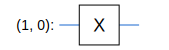

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[1, 0]])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

# Quantum Neural Network
Building the model circuit (here using 2 qubit gates)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

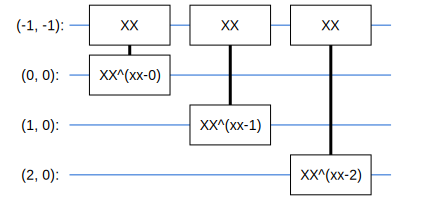

In [ ]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(3,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

We now prepare the 2 qubit model with readout and preparation operations

In [ ]:
def create_quantum_model():
    
    data_qubits = cirq.GridQubit.rect(3, 3)  # a 3x3 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    circuit.append(cirq.H(readout))#additional hadamard gate added

    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

# **Integrating Cirq with TensorFlow Quantum**
We attempt to build the keras model with Quantum components. The model uses a parametrized quantum circuit to train the model circuit on quantum data so obtained from x_train_circ

In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

We now train the model using compile and Hinge Loss, we consider the Adam optimizer

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
None


# **Training the Quantum Model**

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:5000]
y_train_hinge_sub = y_train_hinge[:5000]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
157/157 [==============================] - 7s 39ms/step - loss: 1.0000 - hinge_accuracy: 0.4718 - val_loss: 1.0000 - val_hinge_accuracy: 0.4905
Epoch 2/3
157/157 [==============================] - 5s 34ms/step - loss: 1.0000 - hinge_accuracy: 0.5423 - val_loss: 1.0000 - val_hinge_accuracy: 0.5991
Epoch 3/3
63/63 [==============================] - 1s 14ms/step - loss: 1.0000 - hinge_accuracy: 0.5624


In [ ]:
EPOCHS = 5
BATCH_SIZE = 18

NUM_EXAMPLES = len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:3000]
y_train_hinge_sub = y_train_hinge[:3000]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=18,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
167/167 [==============================] - 4s 25ms/step - loss: 1.0000 - hinge_accuracy: 0.5966 - val_loss: 1.0000 - val_hinge_accuracy: 0.6261
Epoch 2/5
167/167 [==============================] - 4s 24ms/step - loss: 1.0000 - hinge_accuracy: 0.6193 - val_loss: 1.0000 - val_hinge_accuracy: 0.6275
Epoch 3/5
167/167 [==============================] - 4s 24ms/step - loss: 1.0000 - hinge_accuracy: 0.6083 - val_loss: 1.0000 - val_hinge_accuracy: 0.5843
Epoch 4/5
167/167 [==============================] - 4s 24ms/step - loss: 1.0000 - hinge_accuracy: 0.5843 - val_loss: 1.0000 - val_hinge_accuracy: 0.5758
Epoch 5/5
63/63 [==============================] - 1s 14ms/step - loss: 1.0000 - hinge_accuracy: 0.5361


In [ ]:
def create_quantum_model():
    
    data_qubits = cirq.GridQubit.rect(3, 3)  # a 3x3 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
EPOCHS = 5
BATCH_SIZE = 18

NUM_EXAMPLES = len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:1000]
y_train_hinge_sub = y_train_hinge[:1000]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=18,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
56/56 [==============================] - 2s 34ms/step - loss: 1.0000 - hinge_accuracy: 0.6020 - val_loss: 1.0000 - val_hinge_accuracy: 0.5411
Epoch 2/5
56/56 [==============================] - 2s 33ms/step - loss: 1.0000 - hinge_accuracy: 0.6004 - val_loss: 1.0000 - val_hinge_accuracy: 0.5436
Epoch 3/5
56/56 [==============================] - 2s 33ms/step - loss: 1.0000 - hinge_accuracy: 0.6030 - val_loss: 1.0000 - val_hinge_accuracy: 0.5481
Epoch 4/5
56/56 [==============================] - 2s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.6024 - val_loss: 1.0000 - val_hinge_accuracy: 0.5436
Epoch 5/5
63/63 [==============================] - 1s 14ms/step - loss: 1.0000 - hinge_accuracy: 0.5436


In [ ]:
EPOCHS = 5
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:1000]
y_train_hinge_sub = y_train_hinge[:1000]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=18,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
56/56 [==============================] - 2s 36ms/step - loss: 1.0000 - hinge_accuracy: 0.6050 - val_loss: 1.0000 - val_hinge_accuracy: 0.5436
Epoch 2/5
56/56 [==============================] - 2s 36ms/step - loss: 1.0000 - hinge_accuracy: 0.6024 - val_loss: 1.0000 - val_hinge_accuracy: 0.5431
Epoch 3/5
56/56 [==============================] - 2s 36ms/step - loss: 1.0000 - hinge_accuracy: 0.6050 - val_loss: 1.0000 - val_hinge_accuracy: 0.5436
Epoch 4/5
56/56 [==============================] - 2s 36ms/step - loss: 1.0000 - hinge_accuracy: 0.6042 - val_loss: 1.0000 - val_hinge_accuracy: 0.5431
Epoch 5/5
63/63 [==============================] - 1s 15ms/step - loss: 1.0000 - hinge_accuracy: 0.5431


In [ ]:
EPOCHS = 5
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)
x_train_tfcirc_sub = x_train_tfcirc[:2000]
y_train_hinge_sub = y_train_hinge[:2000]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
63/63 [==============================] - 3s 43ms/step - loss: 1.0000 - hinge_accuracy: 0.5784 - val_loss: 1.0000 - val_hinge_accuracy: 0.5431
Epoch 2/5
63/63 [==============================] - 3s 43ms/step - loss: 1.0000 - hinge_accuracy: 0.5779 - val_loss: 1.0000 - val_hinge_accuracy: 0.5431
Epoch 3/5
63/63 [==============================] - 3s 46ms/step - loss: 1.0000 - hinge_accuracy: 0.5774 - val_loss: 1.0000 - val_hinge_accuracy: 0.5431
Epoch 4/5
63/63 [==============================] - 3s 46ms/step - loss: 1.0000 - hinge_accuracy: 0.5774 - val_loss: 1.0000 - val_hinge_accuracy: 0.5431
Epoch 5/5
63/63 [==============================] - 1s 16ms/step - loss: 1.0000 - hinge_accuracy: 0.5421


Samples = 200
Epochs =3 
Optimizer= Adam      45.08%%

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

# **NUM_EXAMPLES has a total sample size of 10409 records. Such a huge dataset was taking too long to execute even with a few epochs, so I reduced it to fewer samples like 200, 400 etc.**

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
NUM_EXAMPLES

11800

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:200] # We try with 200 samples because NUM_EXAMPLES takes too long to execute
y_train_hinge_sub = y_train_hinge[:200]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
369/369 [==============================] - 12s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.5880 - val_loss: 1.0000 - val_hinge_accuracy: 0.7362
Epoch 2/5
369/369 [==============================] - 12s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.7112 - val_loss: 1.0000 - val_hinge_accuracy: 0.7307
Epoch 3/5
369/369 [==============================] - 12s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.7088 - val_loss: 1.0000 - val_hinge_accuracy: 0.7307
Epoch 4/5
369/369 [==============================] - 13s 34ms/step - loss: 1.0000 - hinge_accuracy: 0.7087 - val_loss: 1.0000 - val_hinge_accuracy: 0.7307
Epoch 5/5
63/63 [==============================] - 1s 16ms/step - loss: 1.0000 - hinge_accuracy: 0.7312


In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
EPOCHS = 5
BATCH_SIZE = 18
x_train_tfcirc_sub = x_train_tfcirc[:7000] 
y_train_hinge_sub = y_train_hinge[:7000]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
219/219 [==============================] - 8s 35ms/step - loss: 1.0000 - hinge_accuracy: 0.7062 - val_loss: 1.0000 - val_hinge_accuracy: 0.7312
Epoch 2/5
219/219 [==============================] - 7s 34ms/step - loss: 1.0000 - hinge_accuracy: 0.7063 - val_loss: 1.0000 - val_hinge_accuracy: 0.7312
Epoch 3/5
219/219 [==============================] - 7s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.7061 - val_loss: 1.0000 - val_hinge_accuracy: 0.7307
Epoch 4/5
219/219 [==============================] - 7s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.7063 - val_loss: 1.0000 - val_hinge_accuracy: 0.7307
Epoch 5/5
63/63 [==============================] - 1s 14ms/step - loss: 1.0000 - hinge_accuracy: 0.7307


In [ ]:
EPOCHS = 5
BATCH_SIZE = 18
x_train_tfcirc_sub = x_train_tfcirc[:9000] 
y_train_hinge_sub = y_train_hinge[:9000]

qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/5
282/282 [==============================] - 9s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.7071 - val_loss: 1.0000 - val_hinge_accuracy: 0.7357
Epoch 2/5
282/282 [==============================] - 9s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.7119 - val_loss: 1.0000 - val_hinge_accuracy: 0.7372
Epoch 3/5
282/282 [==============================] - 9s 32ms/step - loss: 1.0000 - hinge_accuracy: 0.7159 - val_loss: 1.0000 - val_hinge_accuracy: 0.7417
Epoch 4/5
282/282 [==============================] - 10s 34ms/step - loss: 1.0000 - hinge_accuracy: 0.7172 - val_loss: 1.0000 - val_hinge_accuracy: 0.7467
Epoch 5/5
63/63 [==============================] - 1s 15ms/step - loss: 1.0000 - hinge_accuracy: 0.7422


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:200]
y_train_hinge_sub = y_train_hinge[:200]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
7/7 [==============================] - 37s 6s/step - loss: 1.0005 - hinge_accuracy: 0.5112 - val_loss: 1.0002 - val_hinge_accuracy: 0.4612
Epoch 2/3
7/7 [==============================] - 37s 6s/step - loss: 0.9998 - hinge_accuracy: 0.5036 - val_loss: 0.9995 - val_hinge_accuracy: 0.5244
Epoch 3/3
63/63 [==============================] - 25s 390ms/step - loss: 0.9991 - hinge_accuracy: 0.5333


## **200, epochs 3 , optimizer = Adagrad    53.38**




In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adagrad(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:200]
y_train_hinge_sub = y_train_hinge[:200]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
7/7 [==============================] - 37s 6s/step - loss: 1.0000 - hinge_accuracy: 0.4809 - val_loss: 0.9991 - val_hinge_accuracy: 0.5333
Epoch 2/3
7/7 [==============================] - 36s 6s/step - loss: 0.9993 - hinge_accuracy: 0.5033 - val_loss: 0.9990 - val_hinge_accuracy: 0.5333
Epoch 3/3
63/63 [==============================] - 25s 388ms/step - loss: 0.9990 - hinge_accuracy: 0.5338


## 200, epochs 3 , optimizer= Nadam  , 54.87 %



In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Nadam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:200]
y_train_hinge_sub = y_train_hinge[:200]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
7/7 [==============================] - 37s 6s/step - loss: 0.9997 - hinge_accuracy: 0.4834 - val_loss: 0.9986 - val_hinge_accuracy: 0.5522
Epoch 2/3
7/7 [==============================] - 37s 6s/step - loss: 0.9991 - hinge_accuracy: 0.5044 - val_loss: 0.9980 - val_hinge_accuracy: 0.5522
Epoch 3/3
63/63 [==============================] - 25s 390ms/step - loss: 0.9973 - hinge_accuracy: 0.5487


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:75]
y_train_hinge_sub = y_train_hinge[:75]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
3/3 [==============================] - 31s 14s/step - loss: 0.9881 - hinge_accuracy: 0.5777 - val_loss: 0.9844 - val_hinge_accuracy: 0.6817
Epoch 2/3
3/3 [==============================] - 31s 14s/step - loss: 0.9867 - hinge_accuracy: 0.6174 - val_loss: 0.9841 - val_hinge_accuracy: 0.6817
Epoch 3/3
63/63 [==============================] - 26s 412ms/step - loss: 0.9837 - hinge_accuracy: 0.6727


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:20]
y_train_hinge_sub = y_train_hinge[:20]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
1/1 [==============================] - 27s 27s/step - loss: 0.9854 - hinge_accuracy: 0.5500 - val_loss: 0.9835 - val_hinge_accuracy: 0.6563
Epoch 2/3
1/1 [==============================] - 27s 27s/step - loss: 0.9850 - hinge_accuracy: 0.5500 - val_loss: 0.9834 - val_hinge_accuracy: 0.6563
Epoch 3/3
63/63 [==============================] - 26s 412ms/step - loss: 0.9832 - hinge_accuracy: 0.6638


In [ ]:
NUM_EXAMPLES

10409

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:100]
y_train_hinge_sub = y_train_hinge[:100]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
4/4 [==============================] - 32s 10s/step - loss: 0.9819 - hinge_accuracy: 0.6641 - val_loss: 0.9821 - val_hinge_accuracy: 0.6275
Epoch 2/3
4/4 [==============================] - 32s 10s/step - loss: 0.9803 - hinge_accuracy: 0.5703 - val_loss: 0.9803 - val_hinge_accuracy: 0.6469
Epoch 3/3
63/63 [==============================] - 26s 413ms/step - loss: 0.9787 - hinge_accuracy: 0.6380


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES-10000]  #considering 409 as number of examples
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES-10000]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
13/13 [==============================] - 54s 4s/step - loss: 0.9764 - hinge_accuracy: 0.6784 - val_loss: 0.9674 - val_hinge_accuracy: 0.6713
Epoch 2/3
13/13 [==============================] - 54s 4s/step - loss: 0.9619 - hinge_accuracy: 0.6804 - val_loss: 0.9563 - val_hinge_accuracy: 0.6827
Epoch 3/3
63/63 [==============================] - 26s 413ms/step - loss: 0.9415 - hinge_accuracy: 0.6843


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:500]  #considering 500 as number of examples
y_train_hinge_sub = y_train_hinge[:500]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
16/16 [==============================] - 61s 4s/step - loss: 0.9288 - hinge_accuracy: 0.6879 - val_loss: 0.9166 - val_hinge_accuracy: 0.6788
Epoch 2/3
16/16 [==============================] - 61s 4s/step - loss: 0.9018 - hinge_accuracy: 0.6824 - val_loss: 0.8878 - val_hinge_accuracy: 0.6768
Epoch 3/3
63/63 [==============================] - 26s 414ms/step - loss: 0.8520 - hinge_accuracy: 0.6931


In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:500]  #considering 500 as number of examples
y_train_hinge_sub = y_train_hinge[:500]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
16/16 [==============================] - 61s 4s/step - loss: 0.8288 - hinge_accuracy: 0.6912 - val_loss: 0.7912 - val_hinge_accuracy: 0.6981
Epoch 2/3
16/16 [==============================] - 61s 4s/step - loss: 0.7514 - hinge_accuracy: 0.7108 - val_loss: 0.7219 - val_hinge_accuracy: 0.6981
Epoch 3/3
63/63 [==============================] - 26s 414ms/step - loss: 0.6744 - hinge_accuracy: 0.6981
